<a href="https://colab.research.google.com/github/waltermaffy/gan_thesis/blob/master/DCGAN_TF_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import keras
from PIL import Image

def warn(*args, **kwargs): #Remove Keras warnings by working with GANs
    pass
import warnings
warnings.warn = warn

Using TensorFlow backend.


## Set up network parameters
 

In [0]:
img_shape = (28, 28, 1)
latent_dim = 100
n_epochs = 10000
batch_size = 64
dataset = 'mnist'
loss = 'binary_crossentropy'
#loss = 'mse'

## Define a function to build a generator

In [0]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Conv2D(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    #model.summary()
    
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

## Define a function to build a discriminator

In [0]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)

## Build GAN

In [5]:
optimizer = Adam(0.0002, 0.5)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Define a function to train GAN

In [0]:
def train(epochs, batch_size=128, save_interval=50):
    os.makedirs('images', exist_ok=True)
    
    if dataset == 'fashion':
      fashion_mnist = keras.datasets.fashion_mnist
      (X_train, _), (_, _) = fashion_mnist.load_data()
    else:
      # Load the dataset
      (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch, show=True)

In [0]:
def save_imgs(epoch, show=False):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.show()
    plt.close()

## Train GAN

11493376/11490434 [==============================] - 1s 0us/step


0 [D loss: 1.410918, acc.: 42.97%] [G loss: 0.355981]


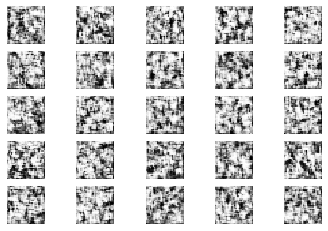

1000 [D loss: 0.749867, acc.: 49.22%] [G loss: 0.930742]


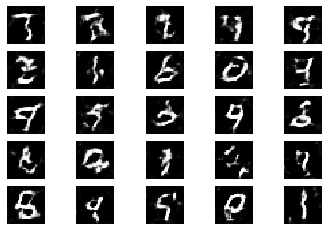

In [0]:
start = time.time()
train(epochs=n_epochs, batch_size=batch_size, save_interval=1000)
end = time.time()

print('elapsed training time: {} min, {} sec '.format(int((end - start) / 60), int((end - start) % 60)))

In [0]:
os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
discriminator.save_weights('saved_model_weights/discriminator_weights.h5')
combined.save_weights('saved_model_weights/combined_weights.h5')

## Show generated MNIST images

In [0]:
Image.open('images/mnist_1000.png')

In [0]:
Image.open('images/mnist_9000.png')